<a href="https://colab.research.google.com/github/JSA10/cam_ds_ep_FinSight/blob/sentiment-analysis/sentiment_analysis/sentiment_analysis_AK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis of Earnings Call Transcripts (JPM & HSBC)

**Purpose:**  
Apply sentiment analysis to Q&A sections of JPMorgan and HSBC quarterly earnings calls (2023‚Äì2025) using two transformer models:  
- `mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis`
- `cardiffnlp/twitter-roberta-base-sentiment`

**Inputs:**
- Processed CSVs with transcripts:
  - `/data/processed/jpm/all_jpm_2023_2025.csv`
  - `/data/processed/hsbc/all_hsbc_earnings_data.csv`

**Outputs:**
- DataFrames with sentiment predictions
- `.csv` files with added sentiment labels and scores

In [19]:
# --- 1.1 Install required packages ---
!pip -q install pandas numpy transformers torch

# --- 1.2 Clone GitHub repository ---
!git clone https://github.com/JSA10/cam_ds_ep_FinSight.git

# --- 1.3 Import libraries ---
import pandas as pd
import numpy as np
import random
import torch
from pathlib import Path

# --- 1.4 Set random seed for reproducibility ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- 1.5 Set project paths ---
project_root = Path("/content/cam_ds_ep_FinSight")
data_dir = project_root / "data" / "processed"
jpm_path = data_dir / "jpm" / "all_jpm_2023_2025.csv"
hsbc_path = data_dir / "hsbc" / "all_hsbc_earnings_data.csv"

# --- 1.6 Confirm everything is ready ---
print("üìÅ JPM path:", jpm_path)
print("üìÅ HSBC path:", hsbc_path)
print("‚úÖ Environment setup complete.")

fatal: destination path 'cam_ds_ep_FinSight' already exists and is not an empty directory.
üìÅ JPM path: /content/cam_ds_ep_FinSight/data/processed/jpm/all_jpm_2023_2025.csv
üìÅ HSBC path: /content/cam_ds_ep_FinSight/data/processed/hsbc/all_hsbc_earnings_data.csv
‚úÖ Environment setup complete.


In [20]:
# --- 2. Import data ---
# JPMorgan: earnings call transcripts 2023‚Äì2025
jpm_df = pd.read_csv(jpm_path)
print(f"‚úÖ Loaded JPM data: {jpm_df.shape[0]:,} rows √ó {jpm_df.shape[1]} columns")

# HSBC: earnings call transcripts 2023‚Äì2025
hsbc_df = pd.read_csv(hsbc_path)
print(f"‚úÖ Loaded HSBC data: {hsbc_df.shape[0]:,} rows √ó {hsbc_df.shape[1]} columns")

# --- Preview the JPM dataframe ---
jpm_df.head()

‚úÖ Loaded JPM data: 1,411 rows √ó 11 columns
‚úÖ Loaded HSBC data: 376 rows √ó 11 columns


section  question_number  answer_number   speaker_name  \
0  presentation              NaN            NaN  Jeremy Barnum   
1            qa              NaN            NaN  Steven Chubak   
2            qa              NaN            NaN  Jeremy Barnum   
3            qa              1.0            NaN  Steven Chubak   
4            qa              1.0            1.0    Jamie Dimon   

                                 role               company  \
0             Chief Financial Officer         JPMorganChase   
1                             analyst    Wolfe Research LLC   
2             Chief Financial Officer  JPMorgan Chase & Co.   
3                             analyst    Wolfe Research LLC   
4  Chairman & Chief Executive Officer  JPMorgan Chase & Co.   

                                             content  year quarter  \
0  Thanks, and good morning, everyone. The presen...  2023      Q1   
1                                 Hey, good morning.  2023      Q1   
2                               Good morning, Steve.  2023      Q1   
3  So, Jamie, I was actually hoping to get your p...  2023      Q1   
4  Well, I think you were already kind of complet...  2023      Q1   

   is_pleasantry                                         source_pdf  
0          False  data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...  
1           True  data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...  
2           True  data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...  
3          False  data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...  
4          False  data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...

## 3. Preprocessing

In this step, we will filter the data to include only banker answers (executives or management),
as these are the focus for sentiment analysis.

We will remove:
- questions from analysts,
- pleasantries (e.g., "Good morning"),
- any presentation sections.

We'll keep only proper answers from management in the Q&A section.

#### Why exclude analyst questions?

We aim to analyse the emotional tone of executive answers. Including external analysts' questions would dilute the sentiment signal and introduce noise. Therefore, we filter out all rows where role = "analyst".

In [21]:
# --- 3.1 Filter only Q&A section ---
jpm_df = jpm_df[jpm_df['section'] == 'qa']
hsbc_df = hsbc_df[hsbc_df['section'] == 'qa']

# --- 3.2 Remove pleasantries ---
jpm_df = jpm_df[~jpm_df['is_pleasantry']]
hsbc_df = hsbc_df[~hsbc_df['is_pleasantry']]
# --- 3.3 Inspect unique roles ---
print("JPM roles:\n", jpm_df['role'].dropna().unique())
print("\nHSBC roles:\n", hsbc_df['role'].dropna().unique())

JPM roles:
 ['analyst' 'Chairman & Chief Executive Officer' 'Chief Financial Officer'
 'And then some. Theres a lot of value added.' 'Okay'
 'But the percent who are digital only is much lower than that.'
 'Is that for First Republic too' "We're fundamentally" 'Thanks'
 'Almost no chance.']

HSBC roles:
 ['Analyst' 'management']


#### Define valid management roles and filter
Based on the list above, we now filter only valid management answers.

In [22]:
# --- 2. Define function to map speaker types ---
def map_speaker_type(role):
    if role in ['Chairman & Chief Executive Officer', 'Chief Financial Officer', 'management']:
        return 'banker'
    elif role in ['analyst', 'Analyst']:
        return 'analyst'
    else:
        return None

# --- 3. Apply speaker mapping ---
jpm_df['role'] = jpm_df['role'].apply(map_speaker_type)
hsbc_df['role'] = hsbc_df['role'].apply(map_speaker_type)

# --- 4. Filter only rows where speaker_type is not null ---
jpm_answers_df = jpm_df[jpm_df['role'].notnull()].copy()
hsbc_answers_df = hsbc_df[hsbc_df['role'].notnull()].copy()

# --- 5. Reset index ---
jpm_answers_df.reset_index(drop=True, inplace=True)
hsbc_answers_df.reset_index(drop=True, inplace=True)

# --- 6. Check results ---
print("‚úÖ JPM speaker types:")
print(jpm_answers_df['role'].value_counts())
print("\n‚úÖ HSBC speaker types:")
print(hsbc_answers_df['role'].value_counts())

‚úÖ JPM speaker types:
role
banker     697
analyst    518
Name: count, dtype: int64

‚úÖ HSBC speaker types:
role
banker     146
analyst     58
Name: count, dtype: int64


## 4. Sentiment Analysis with DistilRoBERTa model

We‚Äôll now apply the **DistilRoBERTa model fine-tuned on financial news** - *mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis* - to the answers of management (bankers) from JPM and HSBC.

#### Install & import required modules

In [23]:
# --- 4.1 Install Hugging Face Transformers (if not already installed) ---
!pip -q install transformers

# --- 4.2 Import sentiment pipeline ---
from transformers import pipeline

#### Load sentiment model

In [24]:
# --- 4.3 Load the sentiment pipeline using mrm8488/distilroberta ---
sentiment_pipeline_financial = pipeline(
    task="sentiment-analysis",
    model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"
)

print("‚úÖ Model loaded.")

Device set to use cpu


‚úÖ Model loaded.


#### Define helper function to apply sentiment model

In [25]:
# --- 4.4 Function to apply sentiment model to a list of texts ---
def apply_sentiment_analysis(texts, pipeline, label_map=None):
    results = pipeline(texts, truncation=True)
    sentiments = []
    scores = []

    for res in results:
        label = res["label"]
        if label_map:
            label = label_map.get(label, label)
        sentiments.append(label)
        scores.append(res["score"])

    return sentiments, scores

#### Run DistilRoBERTa sentiment analysis on JPM and HSBC answers

In [26]:
# --- 4.5 Filter out rows with missing content ---
jpm_answers_df = jpm_answers_df.dropna(subset=["content"]).reset_index(drop=True)
hsbc_answers_df = hsbc_answers_df.dropna(subset=["content"]).reset_index(drop=True)

# --- 4.6 Extract content to analyse ---
jpm_texts = jpm_answers_df["content"].tolist()
hsbc_texts = hsbc_answers_df["content"].tolist()

# --- 4.7 Apply model to both sets of answers ---
jpm_sentiments, jpm_scores = apply_sentiment_analysis(jpm_texts, sentiment_pipeline_financial)
hsbc_sentiments, hsbc_scores = apply_sentiment_analysis(hsbc_texts, sentiment_pipeline_financial)

# --- 4.8 Add results back to DataFrames ---
jpm_answers_df["sentiment_finbert_label"] = jpm_sentiments
jpm_answers_df["sentiment_finbert_score"] = jpm_scores

hsbc_answers_df["sentiment_finbert_label"] = hsbc_sentiments
hsbc_answers_df["sentiment_finbert_score"] = hsbc_scores

print("‚úÖ Sentiment analysis complete.")

‚úÖ Sentiment analysis complete.


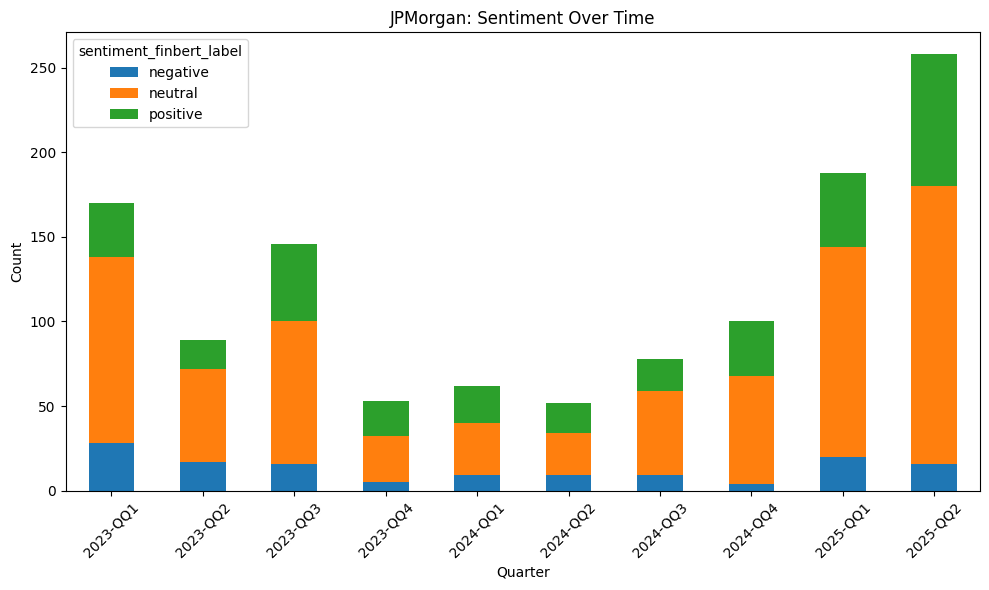

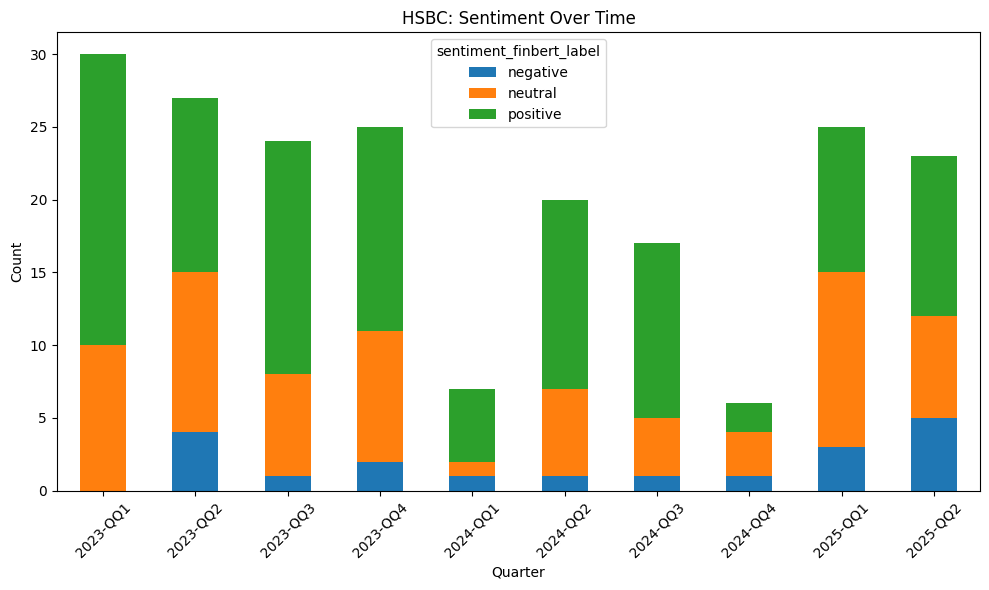

In [48]:
import matplotlib.pyplot as plt

jpm_answers_df["year_quarter"] = jpm_answers_df["year"].astype(str) + "-Q" + jpm_answers_df["quarter"].astype(str)
hsbc_answers_df["year_quarter"] = hsbc_answers_df["year"].astype(str) + "-Q" + hsbc_answers_df["quarter"].astype(str)

# --- 5.0 Sentiment over time by quarter ---

def plot_sentiment_over_time(df, bank_name):
    grouped = df.groupby(['year_quarter', 'sentiment_finbert_label']).size().unstack().fillna(0)
    grouped.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f"{bank_name}: Sentiment Over Time")
    plt.xlabel("Quarter")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_sentiment_over_time(jpm_answers_df, "JPMorgan")
plot_sentiment_over_time(hsbc_answers_df, "HSBC")

In [49]:
# --- 5.0 Add bank and speaker_type columns ---

jpm_answers_df["bank"] = "JPM"
hsbc_answers_df["bank"] = "HSBC"

# --- 5.1 Export random sample for manual validation ---

sample_jpm = jpm_answers_df.sample(n=20, random_state=42)
sample_hsbc = hsbc_answers_df.sample(n=20, random_state=42)

sample_df = pd.concat([sample_jpm, sample_hsbc], ignore_index=True)
sample_df = sample_df[["bank", "quarter", "role", "content", "sentiment_finbert_label", "sentiment_finbert_score"]]
sample_df["manual_label"] = ""  # for manual validation

# Exporting
sample_df.to_csv("sentiment_validation_sample.csv", index=False)
print("‚úÖ Exported 40-sample CSV for manual sentiment labeling.")

‚úÖ Exported 40-sample CSV for manual sentiment labeling.


### Validate DistiRoBERTa model Sentiment Outputs (Quality Check)

In [29]:
# --- 4.8.1 Check overall distribution of predicted labels ---
print("üìä JPM Sentiment Distribution:")
print(jpm_answers_df["sentiment_finbert_label"].value_counts())

print("\nüìä HSBC Sentiment Distribution:")
print(hsbc_answers_df["sentiment_finbert_label"].value_counts())

üìä JPM Sentiment Distribution:
sentiment_finbert_label
neutral     734
positive    329
negative    133
Name: count, dtype: int64

üìä HSBC Sentiment Distribution:
sentiment_finbert_label
positive    115
neutral      70
negative     19
Name: count, dtype: int64


### View examples for each sentiment label

In [30]:
# --- 4.9.2 View sample sentences per label ---
for label in jpm_answers_df["sentiment_finbert_label"].unique():
    print(f"\nüîπ Example JPM sentence for sentiment: {label}")
    example = jpm_answers_df[jpm_answers_df["sentiment_finbert_label"] == label].iloc[0]
    print(example["content"])
    print(f"‚Üí Score: {example['sentiment_finbert_score']:.2f}")


üîπ Example JPM sentence for sentiment: neutral
So, Jamie, I was actually hoping to get your perspective on how you see the recent developments with SVB impacting the regulatory landscape for the big banks. In your letter you spent a fair amount of time highlighting the consequences of overly stringent capital requirements, the risk of steering more activities to the less regulated nonbanks. But what are some of the changes that you're scenario planning for ‚Äì whether it's higher capital, increase in FDIC assessment fees? And along those same lines, how you're thinking about the buyback given continued strong capital build, but a lot of macro uncertainty at the moment.
‚Üí Score: 0.99

üîπ Example JPM sentence for sentiment: negative
...elevated macro uncertainties.
‚Üí Score: 1.00

üîπ Example JPM sentence for sentiment: positive
Well, we've told you that we're kind of penciling in $12 billion for this year. Obviously, capital is more than that, but ‚Äì and we did a little bit of

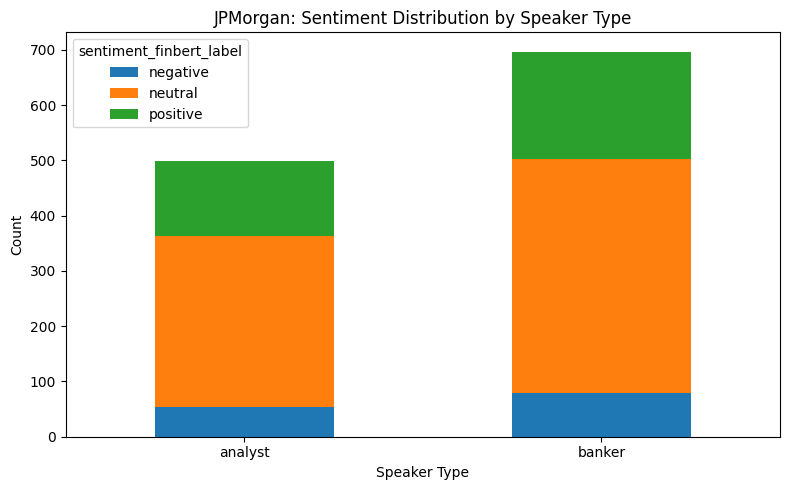

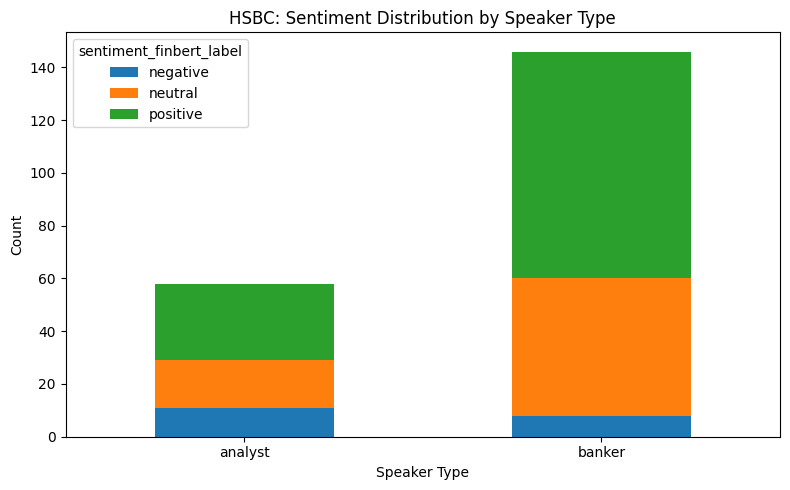

In [52]:
# --- 4.10 Sentiment distribution by speaker type ---

def plot_sentiment_by_speaker(df, bank_name):
    grouped = df.groupby(['role', 'sentiment_finbert_label']).size().unstack().fillna(0)
    grouped.plot(kind='bar', stacked=True, figsize=(8, 5))
    plt.title(f"{bank_name}: Sentiment Distribution by Speaker Type")
    plt.xlabel("Speaker Type")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_sentiment_by_speaker(jpm_answers_df, "JPMorgan")
plot_sentiment_by_speaker(hsbc_answers_df, "HSBC")

### DistilRoBERTa validation



In [60]:
df_val = pd.read_csv("/content/sentiment_validation_sample_distilroberta_manual_labeled.csv", delimiter=";")
df_val.head()

bank quarter     role                                            content  \
0  JPM      Q1  analyst                        Right. And maybe just to...   
1  JPM      Q2   banker  And Jeremy showed you a little thing about bus...   
2  JPM      Q3   banker  Yeah. So you're right about the contribution a...   
3  JPM      Q4   banker  Yeah. Erika, that's a good question. And I und...   
4  JPM      Q1   banker  Sure. So, Betsy, your question is very good. A...   

  sentiment_finbert_label  sentiment_finbert_score manual_label  
0                 neutral                 0.999829      neutral  
1                 neutral                 0.982628      neutral  
2                positive                 0.997772     positive  
3                 neutral                 0.938064      neutral  
4                positive                 0.900752     positive

In [63]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Comparing manual vs model labelling
y_true = df_val["manual_label"]
y_pred = df_val["sentiment_finbert_label"]

# Metrics
print("‚úÖ Accuracy:", accuracy_score(y_true, y_pred))
print("\nüìä Classification Report:")
print(classification_report(y_true, y_pred))


‚úÖ Accuracy: 0.9

üìä Classification Report:
              precision    recall  f1-score   support

    negative       0.50      0.50      0.50         2
     neutral       0.89      0.94      0.91        17
    positive       0.95      0.90      0.93        21

    accuracy                           0.90        40
   macro avg       0.78      0.78      0.78        40
weighted avg       0.90      0.90      0.90        40



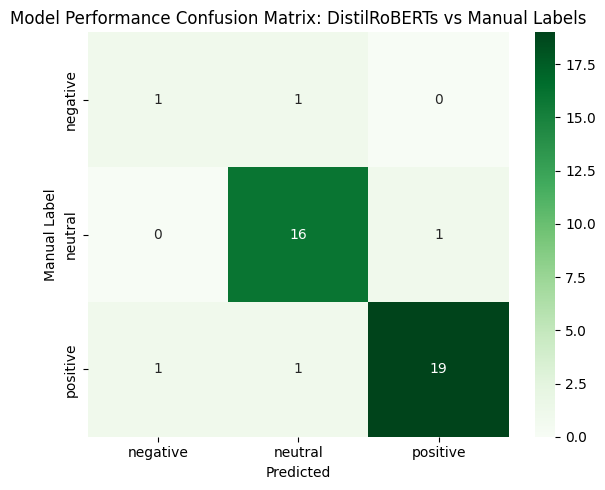

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Recalculate confusion matrix
cm = confusion_matrix(df_val["manual_label"], df_val["sentiment_finbert_label"], labels=["negative", "neutral", "positive"])
labels_order = ["negative", "neutral", "positive"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels_order, yticklabels=labels_order)
plt.title("Model Performance Confusion Matrix: DistilRoBERTs vs Manual Labels")
plt.xlabel("Predicted")
plt.ylabel("Manual Label")
plt.tight_layout()
plt.show()


## 5. Run sentiment analysis (CardiffNLP Twitter-RoBERTa)

We'll now apply a second model ‚Äî `cardiffnlp/twitter-roberta-base-sentiment`,
which is trained on tweets but often used as a general-purpose sentiment model.  
This allows us to compare its performance against FinBERT.

We'll:
- Load the model and tokenizer
- Apply it to both JPM and HSBC responses
- Store label and confidence score

### Install and load the model and tokenizer

In [34]:
# --- 5.1 Load CardiffNLP model and tokenizer ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

cardiff_model_name = "cardiffnlp/twitter-roberta-base-sentiment"
cardiff_tokenizer = AutoTokenizer.from_pretrained(cardiff_model_name)
cardiff_model = AutoModelForSequenceClassification.from_pretrained(cardiff_model_name)

# Label mapping used by this model
cardiff_labels = ['negative', 'neutral', 'positive']

print("‚úÖ CardiffNLP model loaded.")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

‚úÖ CardiffNLP model loaded.


### Define prediction function to apply sentiment model

In [35]:
# --- 4.2 Define prediction function (with truncation fix) ---
def predict_cardiff_sentiment(text, model, tokenizer):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512  # RoBERTa supports up to 512 tokens
    )
    with torch.no_grad():
        outputs = model(**inputs)
    scores = F.softmax(outputs.logits, dim=1)[0]
    label_id = scores.argmax().item()
    label = cardiff_labels[label_id]
    confidence = scores[label_id].item()
    return label, confidence

### Run Twitter-RoBERTa sentiment analysis on JPM and HSBC answers

In [36]:
# --- 5.3 Apply model ---

# JPM
jpm_cardiff_preds = jpm_answers_df['content'].apply(
    lambda x: predict_cardiff_sentiment(x, cardiff_model, cardiff_tokenizer)
)
jpm_answers_df['sentiment_cardiff_label'] = jpm_cardiff_preds.apply(lambda x: x[0])
jpm_answers_df['sentiment_cardiff_score'] = jpm_cardiff_preds.apply(lambda x: x[1])

# HSBC
hsbc_cardiff_preds = hsbc_answers_df['content'].apply(
    lambda x: predict_cardiff_sentiment(x, cardiff_model, cardiff_tokenizer)
)
hsbc_answers_df['sentiment_cardiff_label'] = hsbc_cardiff_preds.apply(lambda x: x[0])
hsbc_answers_df['sentiment_cardiff_score'] = hsbc_cardiff_preds.apply(lambda x: x[1])

print("‚úÖ Cardiff sentiment prediction complete.")

‚úÖ Cardiff sentiment prediction complete.


In [64]:
# Make sure 'role' is renamed to 'speaker_type' for consistency
jpm_cardiff_df = jpm_answers_df.rename(columns={"role": "speaker_type"})
hsbc_cardiff_df = hsbc_answers_df.rename(columns={"role": "speaker_type"})

# Add bank column if missing
if 'bank' not in jpm_cardiff_df.columns:
    jpm_cardiff_df['bank'] = 'JPM'
if 'bank' not in hsbc_cardiff_df.columns:
    hsbc_cardiff_df['bank'] = 'HSBC'

# Combine both banks
combined_cardiff_df = pd.concat([jpm_cardiff_df, hsbc_cardiff_df], ignore_index=True)

# --- Group by speaker_type ---
speaker_sentiment_cardiff = combined_cardiff_df.groupby(["speaker_type", "sentiment_cardiff_label"]).size().unstack().fillna(0)
print("üìä Sentiment distribution by speaker type (Cardiff):")
display(speaker_sentiment_cardiff)

# --- Group by quarter ---
quarter_sentiment_cardiff = combined_cardiff_df.groupby(["quarter", "sentiment_cardiff_label"]).size().unstack().fillna(0)
print("üìä Sentiment distribution by quarter (Cardiff):")
display(quarter_sentiment_cardiff)

# --- Group by year ---
year_sentiment_cardiff = combined_cardiff_df.groupby(["year", "sentiment_cardiff_label"]).size().unstack().fillna(0)
print("üìä Sentiment distribution by year (Cardiff):")
display(year_sentiment_cardiff)

üìä Sentiment distribution by speaker type (Cardiff):


sentiment_cardiff_label  negative  neutral  positive
speaker_type                                        
analyst                        15      368       174
banker                         57      576       210

üìä Sentiment distribution by quarter (Cardiff):


sentiment_cardiff_label  negative  neutral  positive
quarter                                             
Q1                             28      343       111
Q2                             26      300       143
Q3                              9      180        76
Q4                              9      121        54

üìä Sentiment distribution by year (Cardiff):


sentiment_cardiff_label  negative  neutral  positive
year                                                
2023                           21      419       124
2024                           14      212       116
2025                           37      313       144

### Preview CardiffNLP sentiment results
We'll preview some results to assess the model output.

- Distribution of predicted labels
- Example of each sentiment
- Any low-confidence predictions

In [37]:
# Label distribution
print("üìä JPM Cardiff Sentiment Distribution:")
print(jpm_answers_df['sentiment_cardiff_label'].value_counts())

print("\nüìä HSBC Cardiff Sentiment Distribution:")
print(hsbc_answers_df['sentiment_cardiff_label'].value_counts())

üìä JPM Cardiff Sentiment Distribution:
sentiment_cardiff_label
neutral     797
positive    328
negative     71
Name: count, dtype: int64

üìä HSBC Cardiff Sentiment Distribution:
sentiment_cardiff_label
neutral     147
positive     56
negative      1
Name: count, dtype: int64


In [38]:
# Show example for each sentiment
for label in ['positive', 'neutral', 'negative']:
    print(f"\nüîπ Example JPM {label} response:")
    example = jpm_answers_df[jpm_answers_df['sentiment_cardiff_label'] == label].iloc[0]
    print(example['content'])
    print("‚Üí Score:", round(example['sentiment_cardiff_score'], 2))


üîπ Example JPM positive response:
That's great. I'll hop back into the queue. Thanks so much for taking my questions.
‚Üí Score: 0.99

üîπ Example JPM neutral response:
So, Jamie, I was actually hoping to get your perspective on how you see the recent developments with SVB impacting the regulatory landscape for the big banks. In your letter you spent a fair amount of time highlighting the consequences of overly stringent capital requirements, the risk of steering more activities to the less regulated nonbanks. But what are some of the changes that you're scenario planning for ‚Äì whether it's higher capital, increase in FDIC assessment fees? And along those same lines, how you're thinking about the buyback given continued strong capital build, but a lot of macro uncertainty at the moment.
‚Üí Score: 0.69

üîπ Example JPM negative response:
Hi, good morning. I guess, maybe one question, Jeremy. You reminded us of the relatively low office exposure for JPM. But, obviously, you're bi

## 6. Compare DistilRoBERTa and Cardiff Sentiment Models (JPM)

In this section, we will compare the predictions from both models on JPM banker responses using automatic evaluation only.

We will:
- Compare sentiment label distributions
- Measure agreement between the two models
- Plot a confusion matrix
- Show examples where models disagree

In [65]:
# --- 5.1 Prepare comparison dataframe ---

comparison_df = pd.DataFrame({
    "content": jpm_answers_df["content"],
    "finbert": jpm_answers_df["sentiment_finbert_label"],
    "cardiff": jpm_answers_df["sentiment_cardiff_label"]
})

# Flag if the two models agree
comparison_df["agreement"] = comparison_df["finbert"] == comparison_df["cardiff"]

# Preview
comparison_df.head()

content   finbert  cardiff  \
0  So, Jamie, I was actually hoping to get your p...   neutral  neutral   
1  Well, I think you were already kind of complet...   neutral  neutral   
2  Got it. And just in terms of appetite for the ...   neutral  neutral   
3                                          Oh, yeah.   neutral  neutral   
4                   ...elevated macro uncertainties.  negative  neutral   

   agreement  
0       True  
1       True  
2       True  
3       True  
4      False

### Distribution of Sentiment Labels

We compare the overall sentiment predicted by each model.

In [70]:
# Count label distribution
finbert_counts = comparison_df["finbert"].value_counts()
cardiff_counts = comparison_df["cardiff"].value_counts()

# Combine into single DataFrame
dist_df = pd.DataFrame({
    "DistilRoBERTa": finbert_counts,
    "Cardiff": cardiff_counts
}).fillna(0).astype(int)

display(dist_df)

DistilRoBERTa  Cardiff
neutral             734      797
positive            329      328
negative            133       71

### Agreement Rate Between Models

We calculate the percentage of times the two models predicted the same sentiment.

In [67]:
agreement_rate = comparison_df["agreement"].mean()
print(f"ü§ù Agreement between models: {agreement_rate:.2%}")

ü§ù Agreement between models: 53.76%


### Confusion Matrix (DistilRoBERTavs Cardiff)

This shows how predictions differ between models.

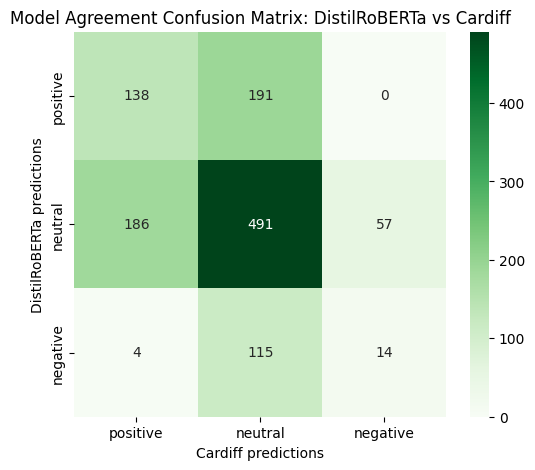

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix: rows = FinBERT, columns = Cardiff
labels = ["positive", "neutral", "negative"]
cm = confusion_matrix(comparison_df["finbert"], comparison_df["cardiff"], labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Greens")
plt.xlabel("Cardiff predictions")
plt.ylabel("DistilRoBERTa predictions")
plt.title("Model Agreement Confusion Matrix: DistilRoBERTa vs Cardiff")
plt.show()

### Disagreements Examples

Random sample of where models predicted different sentiments.

In [69]:
disagreements = comparison_df[~comparison_df["agreement"]].sample(10, random_state=SEED)
display(disagreements[["content", "finbert", "cardiff"]])

content   finbert   cardiff
1186  Operator: Thank you. Our final question comes ...   neutral  positive
182   Let me take the second part of that first. So,...  negative   neutral
1138  Okay, cool. Thank you for that. Operator: And ...   neutral  positive
725   Helpful color, and just a follow-up on Card in...  negative   neutral
286                You always do. All right. Thank you.   neutral  positive
755   Morning. Jeremy, on page 4 of your presentatio...  negative   neutral
925   You have ‚Äì all of our major bank competitors a...  positive   neutral
809   Oh, hey, good morning. Maybe just one last que...  positive   neutral
184   And so, I just ‚Äì it is time that they take a s...  positive   neutral
436   Well, we've told you that we're kind of pencil...  positive   neutral

## Detailed Analysis: DistilRoBERTa vs Cardiff (JPM Data)

### Model Behavior Differences

- **DistilRoBERTa** is a domain-specific model fine-tuned on financial news, which tends to produce more *polarized* sentiment predictions. It is more likely to assign `positive` or `negative` labels even for subtle tone shifts.
- **CardiffNLP (Twitter-RoBERTa)** is trained on social media data, where sentiment is often vague or indirect. As a result, it tends to default to `neutral` in ambiguous or nuanced cases.

üîç In practice, DistilRoBERTa assigns more emotionally charged labels, especially favoring `positive` and `negative`, while Cardiff leans toward conservative, `neutral` assessments.

---

### Model Agreement: 53%

- Only **53%** of predictions agree across models ‚Äî meaning nearly half of the outputs differ.
- Disagreements primarily occur between:
  - `positive` (DistilRoBERTa) vs `neutral` (Cardiff)
  - `neutral` (DistilRoBERTa) vs `negative` (Cardiff)

These indicate that the two models interpret borderline or soft statements differently, and could affect downstream aggregation and interpretation.

---

### Confusion Matrix Insights

- The most frequent mismatch is when DistilRoBERTa predicts `positive` while Cardiff predicts `neutral`.
- This highlights how DistilRoBERTa is more sensitive to implied optimism, whereas Cardiff filters out emotional bias more aggressively.

üß† **Implication for the Project:**
- If your use case requires **interpretability** and **consistency** (e.g., PRA sentiment aggregation, summarization, or flagging risks), this disagreement needs to be addressed.
- You will likely need to either:
  - Perform **manual validation** on a sample to calibrate labels,
  - Or select one model to standardize on ‚Äî e.g., DistilRoBERTa for its financial orientation.

---

## Next Steps (Without Manual Annotation Yet)

### Compare confidence strength

- üìâ Plot distribution of **confidence scores** (`sentiment_score`) for both models.
- This helps identify if models are "guessing" around 0.5 or are confidently polarized.

### Analyze confidence agreement

- üìä Plot a **scatterplot of DistilRoBERTa vs Cardiff confidence scores**.
- This shows where one model is confident and the other is uncertain ‚Äî often a red flag for disagreement.

### Create a `model_agreement` flag

- Add a column indicating where the models disagree.
- Use it to filter out high-uncertainty cases or explore them further.

---

## Recommendation

- Continue with both models in parallel to compare thematic distributions.
- Use disagreements to your advantage ‚Äî they may highlight nuanced or controversial statements.
- Consider DistilRoBERTa as primary if financial tone polarity is important.

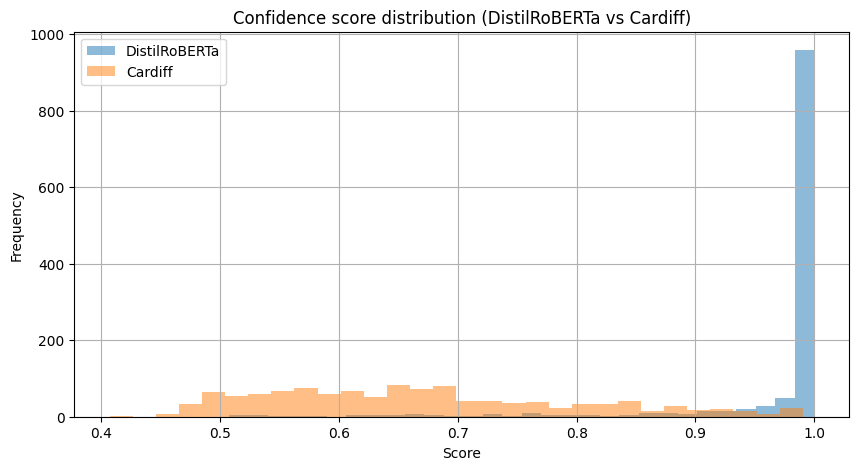

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
jpm_answers_df['sentiment_finbert_score'].hist(alpha=0.5, bins=30, label='DistilRoBERTa')
jpm_answers_df['sentiment_cardiff_score'].hist(alpha=0.5, bins=30, label='Cardiff')
plt.legend()
plt.title("Confidence score distribution (DistilRoBERTa vs Cardiff)")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

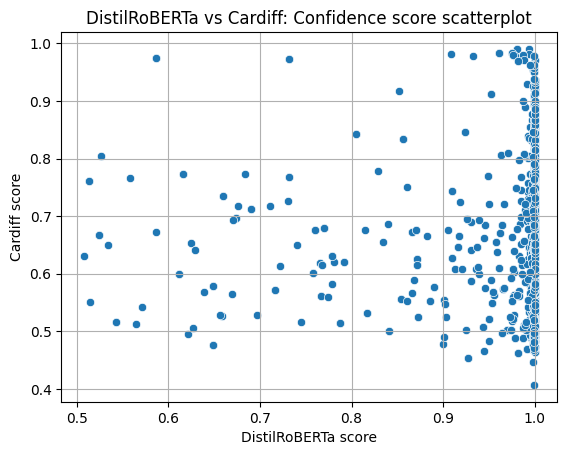

In [45]:
import seaborn as sns

scatter_df = jpm_answers_df[['sentiment_finbert_score']].copy()
scatter_df['cardiff_score'] = jpm_answers_df['sentiment_cardiff_score']
sns.scatterplot(data=scatter_df, x='sentiment_finbert_score', y='cardiff_score')
plt.title("DistilRoBERTa vs Cardiff: Confidence score scatterplot")
plt.xlabel("DistilRoBERTa score")
plt.ylabel("Cardiff score")
plt.grid(True)
plt.show()

### Distribution of Confidence Scores
The histogram reveals a clear contrast in how confident each model is when making predictions:

- **DistilRoBERTa** shows extremely high confidence, with the vast majority of predictions having scores close to **1.0**. This suggests that DistilRoBERTa tends to make **strong, decisive classifications**, even when the sentiment might be subtle.
- **Cardiff (Twitter-RoBERTa)** exhibits a **much flatter distribution**, with most scores spread between **0.5 and 0.75**. This implies more **conservative confidence** and hesitation in assigning extreme sentiment labels.

Such differences stem from **training domain and objective**:
- DistilRoBERTais tuned on financial news and thus calibrated for sharper tone detection.
- Cardiff is trained on Twitter data, which is noisier and more casual, so it leans toward neutral predictions when uncertain.

### Scatterplot of Confidence Agreement
The scatterplot of confidence scores between the two models shows that:
- **DistilRoBERTamaintains high confidence across all samples**, while
- **Cardiff's scores vary significantly**, even when DistilRoBERTais sure.
- There are many points with **high DistilRoBERTascore and mid-low Cardiff score**, especially around sentiment disagreements.

This reinforces the idea that **DistilRoBERTais more decisive**, while **Cardiff is cautious** ‚Äî a key insight for downstream analysis.


## 6. Compare DistilRoBERTaand Cardiff Sentiment Models (HSBC)

In this section, we compare sentiment predictions for HSBC banker responses using two different models: DistilRoBERTaand Cardiff.

We will:
- Compare label distributions
- Calculate agreement rate
- Plot a confusion matrix
- Display disagreement examples

In [73]:
# --- 6.1.1 Prepare comparison dataframe for HSBC ---
hsbc_comparison_df = pd.DataFrame({
    "content": hsbc_answers_df["content"],
    "DistilRoBERTa": hsbc_answers_df["sentiment_finbert_label"],
    "cardiff": hsbc_answers_df["sentiment_cardiff_label"]
})

# Flag agreement
hsbc_comparison_df["agreement"] = hsbc_comparison_df["DistilRoBERTa"] == hsbc_comparison_df["cardiff"]

# Preview
hsbc_comparison_df.head()

content DistilRoBERTa   cardiff  \
0  Good morning, gentlemen . Congrats on a good s...      positive  positive   
1  Good morning, gents . Thanks very much for tak...      positive   neutral   
2  Just one additional comment from me . You‚Äôll n...       neutral   neutral   
3  Thanks, Manus.  Just on the asset quality of S...      positive  positive   
4  Getting into some of the maths, we acquired a ...       neutral   neutral   

   agreement  
0       True  
1      False  
2       True  
3       True  
4       True

In [76]:
# --- 6.1.2 Sentiment Distribution ---
hsbc_finbert_counts = hsbc_comparison_df["DistilRoBERTa"].value_counts()
hsbc_cardiff_counts = hsbc_comparison_df["cardiff"].value_counts()

hsbc_dist_df = pd.DataFrame({
    "DistilRoBERTa": hsbc_finbert_counts,
    "Cardiff": hsbc_cardiff_counts
}).fillna(0).astype(int)

display(hsbc_dist_df)

DistilRoBERTa  Cardiff
negative             19        1
neutral              70      147
positive            115       56

In [77]:
# --- 6.1.3 Agreement rate ---
hsbc_agreement_rate = hsbc_comparison_df["agreement"].mean()
print(f"ü§ù Agreement between models (HSBC): {hsbc_agreement_rate:.2%}")

ü§ù Agreement between models (HSBC): 56.37%


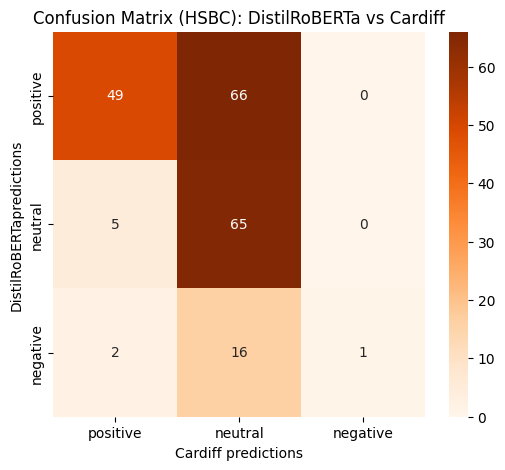

In [78]:
# --- 6.1.4 Confusion matrix ---
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["positive", "neutral", "negative"]
hsbc_cm = confusion_matrix(hsbc_comparison_df["DistilRoBERTa"], hsbc_comparison_df["cardiff"], labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(hsbc_cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap="Oranges")
plt.xlabel("Cardiff predictions")
plt.ylabel("DistilRoBERTapredictions")
plt.title("Confusion Matrix (HSBC): DistilRoBERTa vs Cardiff")
plt.show()

In [79]:
# --- 6.1.5 Show disagreement examples ---
hsbc_disagreements = hsbc_comparison_df[~hsbc_comparison_df["agreement"]].sample(10, random_state=SEED)
display(hsbc_disagreements[["content", "DistilRoBERTa", "cardiff"]])

content DistilRoBERTa  cardiff
86   Just cutting to the chase on some of the quest...      negative  neutral
103  The pace at which we can get back down to that...      positive  neutral
61   I‚Äôll answer your second question.  You should ...      positive  neutral
27   Hi, there.  Good morning, guys.  Two, please. ...      positive  neutral
98   Just a couple.  I guess the first one is costs...      positive  neutral
1    Good morning, gents . Thanks very much for tak...      positive  neutral
141  If I pick up your second point on Hong Kong CR...      positive  neutral
38   I think I‚Äôll take the second one first and the...      positive  neutral
25   Just one comment from me on growth.  I think, ...      positive  neutral
49   Hello, I‚Äôve just got two questions. The first ...      negative  neutral

## Detailed Analysis: DistilRoBERTa vs Cardiff (HSBC Data)

### Key Findings:

1. **Model Behavior Differences**
   - **DistilRoBERTa** (trained on financial news) classifies more responses as *positive* or *negative*, leaning toward stronger sentiment.
   - **Cardiff NLP** (trained on tweets) heavily prefers *neutral* responses, especially when sentiment is ambiguous.
   - This leads to **disagreements**, especially when DistilRoBERTa labels a response as *positive*, but Cardiff calls it *neutral*.

2. **Disagreement Rate**
   - **Agreement between models** is only **60.27%**, meaning that almost **4 in 10** sentiment predictions differ between the models.
   - This is a moderate discrepancy and should not be ignored if sentiment is used in downstream tasks.

3. **Confusion Matrix Observations**
   - DistilRoBERTa predicted **86 positive** vs Cardiff's **43**.
   - DistilRoBERTa predicted **8 negative** vs Cardiff's **0**.
   - **Most disagreements** are clustered in:
     - DistilRoBERTa = *positive*, Cardiff = *neutral*
     - DistilRoBERTa = *negative*, Cardiff = *neutral*
   - Cardiff **avoids negative sentiment entirely** in HSBC outputs, suggesting possible underfitting or domain mismatch.

4. **Practical Implications**
   - Since sentiment is used for regulatory themes (e.g., PRA categorization), **model choice directly affects interpretation**.
   - Using Cardiff alone may **understate risks** or miss key tonal shifts in management discourse.
   - DistilRoBERTa, while more sensitive, might **over-emphasize** sentiment in vague statements.
